## Image Folder Method

Using the image folder method prepares the data that are organised as:

root/Acer_Capillipes/1196.jpg
<br>
root/Acer_Capillipes/227.jpg
<br>
root/Acer_Capillipes/990.jpg

This is very complimentary with how images would be structured in an image folder

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image

from tqdm import tqdm_notebook as tnote
torch.manual_seed(42)

import shutil #Copies files from one dir to another

In [2]:
batch_size = 4 #defines the size of the samples to test against
test_batch_size = 10 #Ensure that your test size produces no remainders (preferebly numbers with the power of 2)

In [3]:
transform = transforms.Compose(
    [transforms.Resize(32),
     transforms.Resize(32),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Formulating Data

In [4]:
# Load in each dataset and apply transformations using
# the torchvision.datasets as datasets library

trainset = torchvision.datasets.ImageFolder(root='./image_dir/train/', transform=transform)

In [5]:
testset = torchvision.datasets.ImageFolder(root='./image_dir/train/', transform=transform)

### Including Data Loader

In [6]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True);
test_loader = torch.utils.data.DataLoader(testset, test_batch_size, shuffle=True);

## Previewing the Data

In [7]:
import matplotlib.pyplot as plt
import numpy as np

In [8]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [9]:
#test classes containing the types expected from this dataset
classes = ('Apes', 'Birds', 'Dogs')

Size of Training Dataset: 30
Size of classes: 3


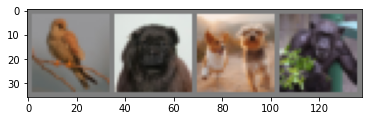

Birds  Dogs  Dogs  Apes


In [10]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

print("Size of Training Dataset: " + str(len(trainset)))
print("Size of classes: " + str(len(classes)))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

## Defining a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).


In [11]:
import torch.nn as nn
import torch.nn.functional as F

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## Define a Loss function and optimiser

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [13]:
import torch.optim as optim

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [15]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Finished Training


In [16]:
PATH = './image_folder_model.pth'
torch.save(net.state_dict(), PATH)

## Testing the Network

Testing the resulted training model

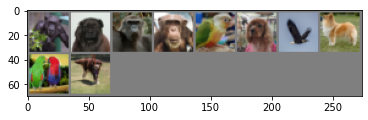

GroundTruth:   Apes  Dogs


In [13]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images directly from test model
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(2)))

In [18]:
#Next, let’s load back in our saved model 
#(note: saving and re-loading the model wasn’t necessary here, we only did it to illustrate how to do so):
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [19]:
outputs = net(images)

In [20]:
_, predicted = torch.max(outputs, 1)

print(predicted)


print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(test_batch_size)))

tensor([0, 2, 0, 0, 0, 2, 2, 0, 2, 1])
Predicted:   Apes  Dogs  Apes  Apes  Apes  Dogs  Dogs  Apes  Dogs Birds


We then check the accuracy of the network over the entire dataset

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 30 test images: 93 %


In [22]:
class_size = len(classes)

class_correct = list(0. for i in range(class_size))
class_total = list(0. for i in range(class_size))

print(len(test_loader))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        print(len(labels))
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(test_batch_size):
            print(labels[i])
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


# Note that tests go over the entire dataset and is dependant on batch size.
# A batch of 8 with a dataset size of 30 will lead to an out-of-bounds with last item with label-size of '6' ('8' expected)

for i in range(class_size):
    print(i)
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

3
10
tensor(1)
tensor(0)
tensor(1)
tensor(2)
tensor(1)
tensor(1)
tensor(0)
tensor(2)
tensor(1)
tensor(2)
10
tensor(0)
tensor(2)
tensor(1)
tensor(2)
tensor(1)
tensor(1)
tensor(2)
tensor(0)
tensor(1)
tensor(2)
10
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(2)
tensor(0)
tensor(1)
tensor(0)
tensor(2)
tensor(0)
0
Accuracy of  Apes : 100 %
1
Accuracy of Birds : 100 %
2
Accuracy of  Dogs : 80 %
